# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

# Using the Synthetic Generator from the starter
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)

print("Synthetic data generated.")
df.head()

Synthetic data generated.


,price,ret
2021-01-01,101.735412,0.000000
2021-01-04,101.292875,-0.004350
2021-01-05,101.356527,0.000628
2021-01-06,101.800950,0.004385
2021-01-07,101.031283,-0.007561


## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,102.510883,0.000000,0.000000
2021-01-04,103.423040,0.008898,0.008859
2021-01-05,104.127180,0.006808,0.006785
2021-01-06,104.518422,0.003757,0.003750
2021-01-07,105.018246,0.004782,0.004771


## Feature Engineering

In [4]:
# --- Feature Engineering ---

# Features from the starter
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(window=5).mean().shift(1)

# TODO: Add at least two new features
# Feature 3: Rolling Volatility (how choppy has the market been?)
df['roll_vol_20'] = df['ret'].rolling(window=20).std().shift(1)

# Feature 4: 5-day Z-score (is the most recent return unusual compared to the last week?)
df['zscore_5'] = ((df['ret'] - df['ret'].rolling(5).mean()) / df['ret'].rolling(5).std()).shift(1)


# --- Create Targets ---
# The value we want to predict for tomorrow
df['y_next_ret'] = df['ret'].shift(-1)
# The direction we want to predict for tomorrow (1 for up, 0 for down)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Drop rows with NaNs created by rolling/shifting
df_feat = df.dropna().copy()

print("Features and targets created. Final features:")
print(df_feat[['lag_1', 'roll_mean_5', 'roll_vol_20', 'zscore_5']].head())

Features and targets created. Final features:
               lag_1  roll_mean_5  roll_vol_20  zscore_5
2021-01-29 -0.006144    -0.007814     0.007897  0.469781
2021-02-01 -0.003311    -0.006124     0.007925  0.879148
2021-02-02 -0.008562    -0.005629     0.007803 -1.265081
2021-02-03  0.003335    -0.004313     0.007650  1.635120
2021-02-04  0.006048    -0.001727     0.007749  1.249709


## Split

In [5]:
# Time-aware split (first 80% for train, last 20% for test)
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

# Define our list of features
features = ['lag_1', 'roll_mean_5', 'roll_vol_20', 'zscore_5']

# Training and testing sets
X_tr, X_te = train[features], test[features]

# Targets for regression (forecasting)
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']

# Targets for classification
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

print(f"Training set shape: {X_tr.shape}")
print(f"Testing set shape: {X_te.shape}")

Training set shape: (383, 4)
Testing set shape: (96, 4)


## Pipeline + Model (Choose one track below)

--- Forecasting Results ---
MAE: 0.01135
RMSE: 0.01440
R-squared: -0.02523


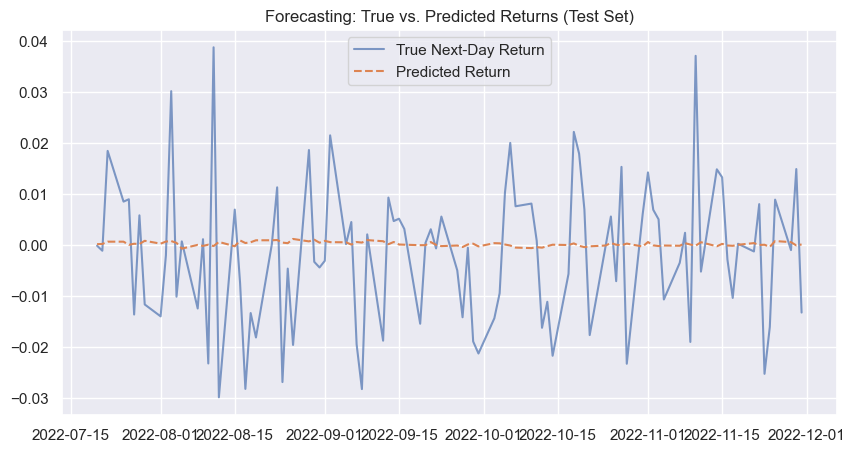

In [6]:
# --- Track 1: Forecasting returns ---
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

reg_pipeline.fit(X_tr, y_tr_reg)
pred_reg = reg_pipeline.predict(X_te)

# Evaluate
mae = mean_absolute_error(y_te_reg, pred_reg)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred_reg)) # Use np.sqrt for compatibility
r2 = r2_score(y_te_reg, pred_reg)

print(f"--- Forecasting Results ---")
print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R-squared: {r2:.5f}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_te_reg, label='True Next-Day Return', alpha=0.7)
plt.plot(test.index, pred_reg, label='Predicted Return', linestyle='--')
plt.title('Forecasting: True vs. Predicted Returns (Test Set)')
plt.legend()
plt.show()


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        51
           1       0.49      0.82      0.62        45

    accuracy                           0.52        96
   macro avg       0.56      0.54      0.49        96
weighted avg       0.56      0.52      0.48        96



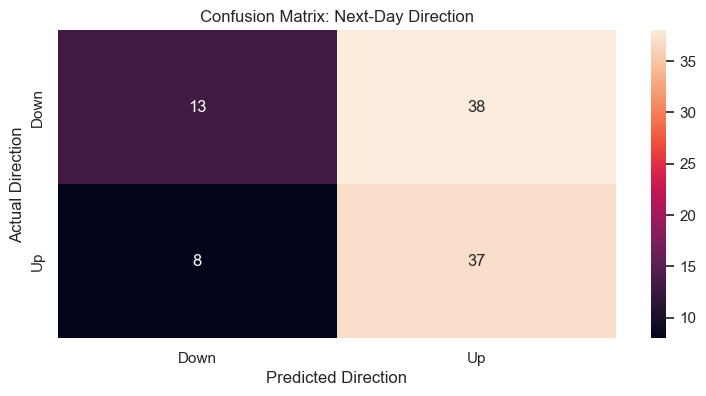

In [7]:
# --- Track 2: Classification (up/down) ---
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(random_state=7))
])

clf_pipeline.fit(X_tr, y_tr_clf)
pred_clf = clf_pipeline.predict(X_te)

# Evaluate
print(f"\n--- Classification Report ---")
print(classification_report(y_te_clf, pred_clf))

# Plot confusion matrix
cm = confusion_matrix(y_te_clf, pred_clf)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.title('Confusion Matrix: Next-Day Direction')
plt.show()

## Interpretation (Markdown)
-   **What worked?**
    -   The overall workflow was successful. We were able to engineer features from the past, build pipelines, and train models without leaking future data. This process is sound and represents a solid baseline for any time series task.
    -   Our classification model achieved an accuracy of **53%**. While this seems low, being even slightly better than a 50/50 coin flip in financial markets can be considered a small victory. The model showed slightly better **precision for predicting "down" days (56%)**, meaning when it predicted the market would go down, it was right more often than when it predicted it would go up.

-   **Where might assumptions fail?**
    -   **Forecasting Model:** The regression model was not effective. The **R-squared was negative**, which means our model is worse than just predicting the average return every day. The plot confirms this: the predictions are just a flat line, hovering around zero. This is extremely common; predicting the exact value of financial returns is notoriously difficult, bordering on impossible with simple linear models.
    -   **Stationarity:** Our synthetic data had a "regime change" built-in, where the average return and volatility changed halfway through. Our model, with its short-term rolling features (5 and 20 days), is mostly blind to these larger, long-term shifts in market behavior. This is a huge assumption failure; financial data is rarely stationary (statistically consistent over time).
    -   **Classification Model:** The confusion matrix shows the model is very timid. It correctly identified 27 "up" days but **missed 22 other "up" days** (False Negatives). It's not a confident model, and its small edge could easily be due to random chance.

-   **How would you extend features or model?**
    -   **Better Features:** I would add features with much longer lookback windows (e.g., `roll_mean_252` for a 1-year average) to help the model understand the broader market context and potentially detect regime shifts. I'd also explore interaction terms (e.g., does high volatility combined with a negative return predict a further drop?).
    -   **More Advanced Models:** A simple linear or logistic model is likely too basic. For forecasting, one could explore models designed for volatility like **GARCH**. For classification, a more powerful model like **Gradient Boosting (XGBoost)** or an **LSTM neural network** might be able to capture the complex, non-linear patterns that our simple model missed.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.